In [1]:
# --- Imports
import warnings, pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay


In [3]:
warnings.filterwarnings("ignore")
sns.set(style="whitegrid", rc={"figure.figsize": (10,6)})

In [4]:
csv_path = Path(r"venv\Scripts\Data Structures\Data Anaylsis\customer_churn_dataset-testing-master.csv")
Data = pd.read_csv(csv_path)

In [5]:
# Quick peek
display(Data.head())
print(Data.info())

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB
None


In [6]:
# --- Basic cleaning
# Drop an ID column if it’s just a surrogate key
if "CustomerID" in Data.columns:
    Data = Data.drop(columns=["CustomerID"])

In [7]:
# Check nulls/dupes
print("Nulls:", Data.isnull().sum().sum())
Data = Data.dropna()
print("Duplicates:", Data.duplicated().sum())


Nulls: 0
Duplicates: 0


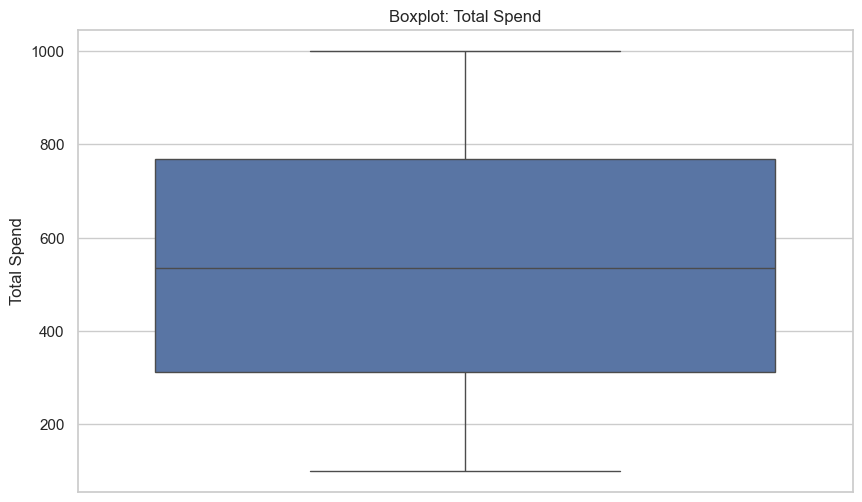

In [8]:
# --- EDA fixes
# Boxplot (correct API)
sns.boxplot(y=Data["Total Spend"])
plt.title("Boxplot: Total Spend")
plt.show()

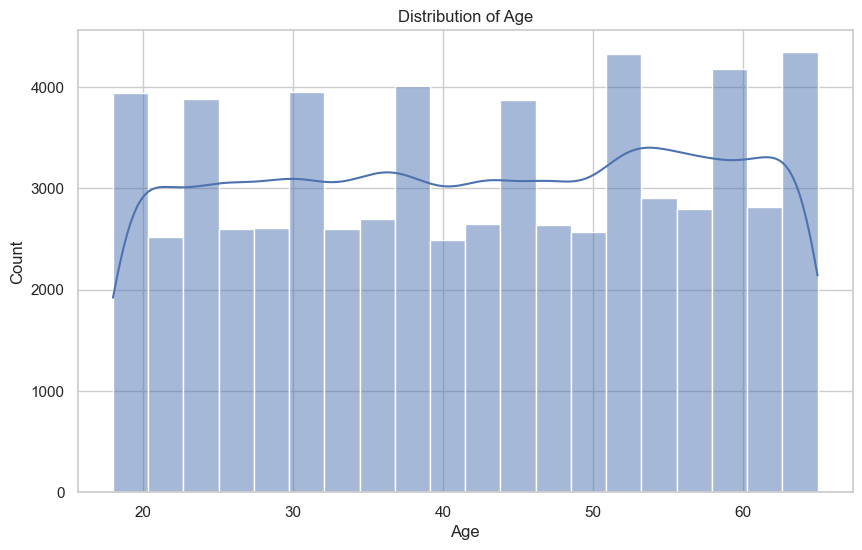

In [9]:
# Histograms
sns.histplot(data=Data, x="Age", kde=True, bins=20)
plt.title("Distribution of Age"); plt.show()

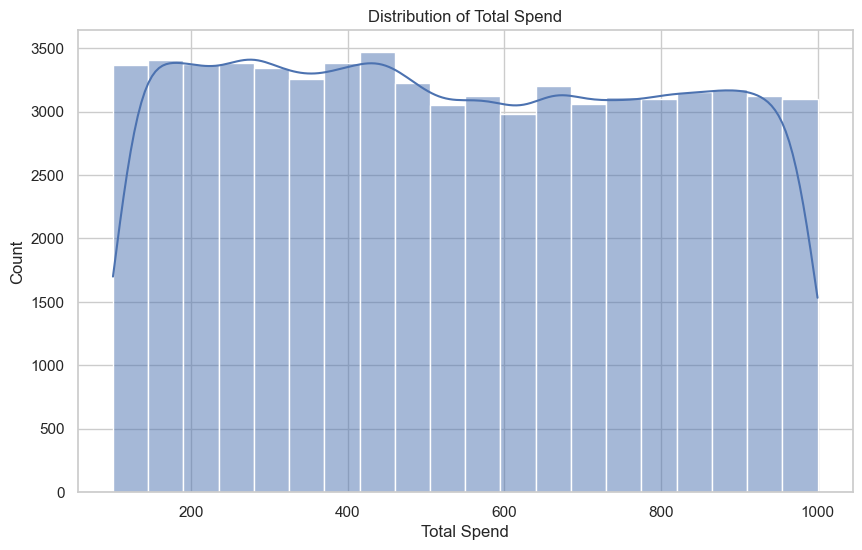

In [10]:
sns.histplot(data=Data, x="Total Spend", kde=True, bins=20)
plt.title("Distribution of Total Spend"); plt.show()

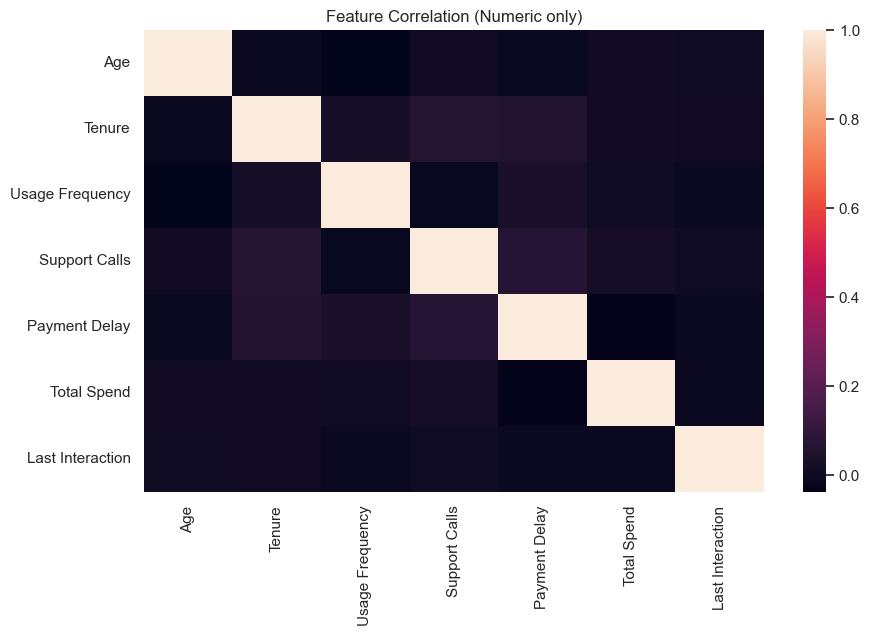

In [11]:
# Heatmap on numeric columns only (excluding target to avoid leakage in viz)
num_cols = Data.select_dtypes(include=[np.number]).columns.tolist()
if "Churn" in num_cols:
    corr_df = Data[num_cols].drop(columns=["Churn"])
else:
    corr_df = Data[num_cols]
sns.heatmap(corr_df.corr(), annot=False)
plt.title("Feature Correlation (Numeric only)"); plt.show()

In [12]:
# --- Features/Target
X = Data.drop(columns=["Churn"])
y = Data["Churn"]


In [13]:
# Identify categorical features (object or category); numeric otherwise
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

Categorical: ['Gender', 'Subscription Type', 'Contract Length']
Numeric: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']


In [14]:
# --- Preprocess: OneHot for categoricals, Scale numerics
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)


In [15]:
# --- Model: LogisticRegressionCV with scaling + one-hot in a Pipeline
pipe = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", LogisticRegressionCV(
            cv=5,
            max_iter=5000,
            n_jobs=-1,
            solver="lbfgs",
            scoring="f1",    # use F1 for imbalanced churn; you can change to 'accuracy'
        )),
    ]
)

In [16]:
# --- Train/test split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [17]:
# --- Fit
pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Tenure',
                                                   'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'Subscription Type',
                                                   'Contract Length'])])),
                ('clf',
                 LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1,
                                      scoring='f1'))])

Accuracy: 0.828 | F1: 0.821
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     10165
           1       0.81      0.83      0.82      9148

    accuracy                           0.83     19313
   macro avg       0.83      0.83      0.83     19313
weighted avg       0.83      0.83      0.83     19313



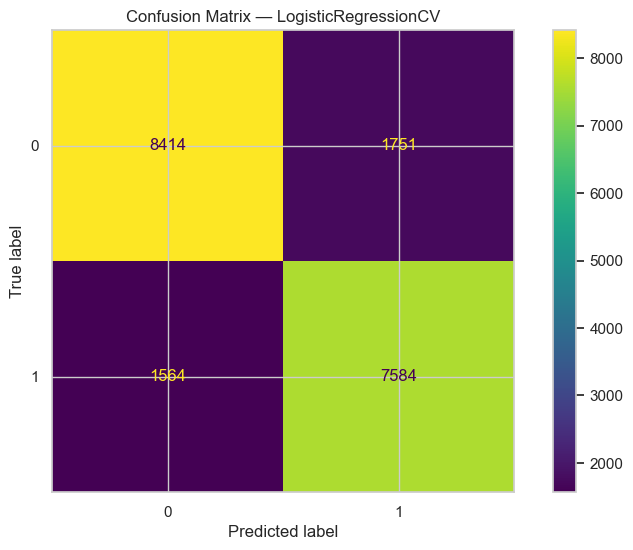

In [18]:
# --- Evaluate
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f} | F1: {f1:.3f}")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — LogisticRegressionCV")
plt.show()